## 1. Environment Setup and Data Loading

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

df = pd.read_csv('../data/raw/IEA-EV-dataEV salesHistoricalCars.csv')
df.head()

,region,category,parameter,mode,powertrain,year,unit,value
0,Australia,Historical,EV sales,Cars,BEV,2011,Vehicles,49.00000
1,Australia,Historical,EV stock share,Cars,EV,2011,percent,0.00039
2,Australia,Historical,EV sales share,Cars,EV,2011,percent,0.00650
3,Australia,Historical,EV stock,Cars,BEV,2011,Vehicles,49.00000
4,Australia,Historical,EV stock,Cars,BEV,2012,Vehicles,220.00000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   region      3798 non-null   object 
 1   category    3798 non-null   object 
 2   parameter   3798 non-null   object 
 3   mode        3798 non-null   object 
 4   powertrain  3798 non-null   object 
 5   year        3798 non-null   int64  
 6   unit        3798 non-null   object 
 7   value       3798 non-null   float64
dtypes: float64(1), int64(1), object(6)
memory usage: 237.5+ KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,3798.0,2017.369932,3.809226,2010.000000,2014.0,2018.0,2021.0,2023.0
value,3798.0,100954.233007,818440.248406,0.000015,2.3,190.0,6800.0,28000000.0


In [5]:
# Get the unique value of parameter and powertrain column
display(df['parameter'].unique())
display(df['powertrain'].unique())

array(['EV sales', 'EV stock share', 'EV sales share', 'EV stock',
       'Electricity demand', 'Oil displacement Mbd',
       'Oil displacement, million lge'], dtype=object)

array(['BEV', 'EV', 'PHEV', 'FCEV'], dtype=object)

## 2. Data Processing

#### 2.1 Check the null data

In [6]:
# Check the null data
df.isnull().sum()

region        0
category      0
parameter     0
mode          0
powertrain    0
year          0
unit          0
value         0
dtype: int64

#### 2.2 Check the duplicated records

In [7]:
# Check the duplicated record
df.duplicated().sum()

0

#### 2.3 Optimize Categorical Data

In [8]:
cat_cols = ['region', 'category', 'parameter', 'mode', 'powertrain', 'unit']
df[cat_cols] = df[cat_cols].astype('category')
df.info()  # Check reduced memory usage

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   region      3798 non-null   category
 1   category    3798 non-null   category
 2   parameter   3798 non-null   category
 3   mode        3798 non-null   category
 4   powertrain  3798 non-null   category
 5   year        3798 non-null   int64   
 6   unit        3798 non-null   category
 7   value       3798 non-null   float64 
dtypes: category(6), float64(1), int64(1)
memory usage: 85.2 KB


#### 2.4 Remove Useless Data

In [9]:
for col in ['region', 'category', 'parameter','mode','unit']:
    print(f"{col}: {df[col].nunique()} unique values")

region: 52 unique values
category: 1 unique values
parameter: 7 unique values
mode: 1 unique values
unit: 5 unique values


In [10]:
df.drop(columns=['category','mode'])

,region,parameter,powertrain,year,unit,value
0,Australia,EV sales,BEV,2011,Vehicles,4.900000e+01
1,Australia,EV stock share,EV,2011,percent,3.900000e-04
2,Australia,EV sales share,EV,2011,percent,6.500000e-03
3,Australia,EV stock,BEV,2011,Vehicles,4.900000e+01
4,Australia,EV stock,BEV,2012,Vehicles,2.200000e+02
...,...,...,...,...,...,...
3793,World,EV stock,BEV,2023,Vehicles,2.800000e+07
3794,World,EV sales,BEV,2023,Vehicles,9.500000e+06
3795,World,EV sales share,EV,2023,percent,1.800000e+01
3796,World,EV stock share,EV,2023,percent,3.200000e+00


#### 2.5 Create log-transformed Target

In [11]:
# Identify skewed numerical features (absolute skew > 0.5)
num_cols = df.select_dtypes(include=np.number).columns
skewed_cols = [col for col in num_cols if abs(df[col].skew()) > 0.5]
display(skewed_cols)

['value']

In [12]:
df['log_value'] = np.log1p(df['value'])

## 3. Exploratory Data Analysis (EDA)

#### 3.1 Temporal Trends

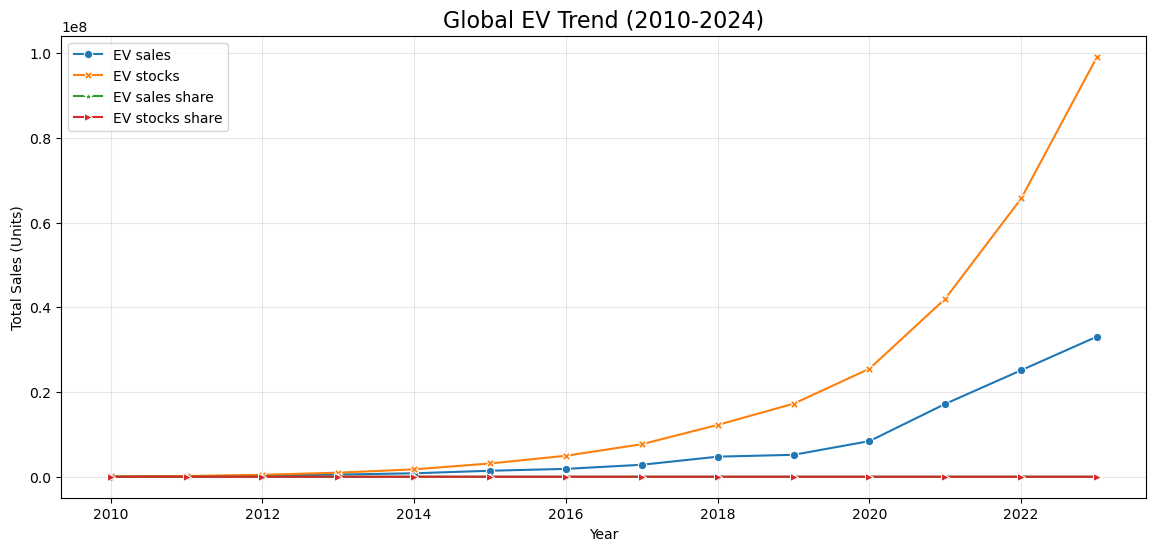

In [13]:
plt.figure(figsize=(14,6))

# data filter by parameters
EV_sales_df = df.query("parameter == 'EV sales'")
EV_stock_df = df.query("parameter == 'EV stock'")
EV_sales_share_df = df.query("parameter == 'EV sales share'")
EV_stock_share_df = df.query("parameter == 'EV stock share'")
sns.lineplot(data=EV_sales_df.groupby('year')['value'].sum(), marker='o',label='EV sales')
sns.lineplot(data=EV_stock_df.groupby('year')['value'].sum(), marker='X', label='EV stocks')
sns.lineplot(data=EV_sales_share_df.groupby('year')['value'].sum(), marker='*', label='EV sales share')
sns.lineplot(data=EV_stock_share_df.groupby('year')['value'].sum(), marker='>', label='EV stocks share')


plt.title('Global EV Trend (2010-2024)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Total Sales (Units)')

# draw gridlines
plt.grid(alpha=0.3)
plt.show()

Text(0.5, 1.0, 'Distribution of EV powertrain types (BEV, PHEV, FCEV, EV)')

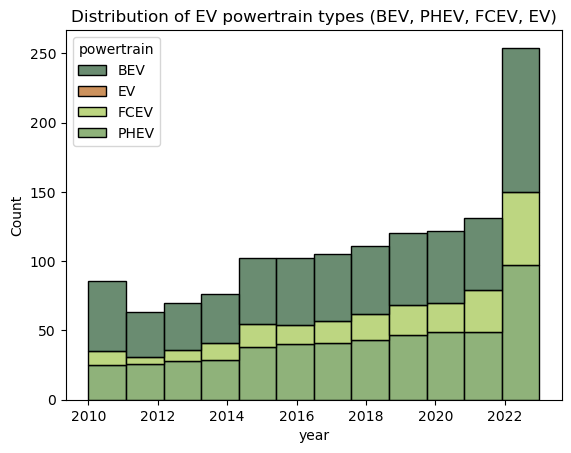

In [14]:
# Define a custom color palette for the 4 powertrain types
palette = {
    "BEV": "#386641",  # Forest green
    "PHEV": "#6a994e",  # Leaf green
    "FCEV": "#a7c957",  # Lime
    "EV": "#bc6c25"     # Earth brown
}
sns.histplot(data=EV_sales_df, x="year", hue="powertrain",
             palette=palette,
             multiple="stack"
             )
plt.title('Distribution of EV powertrain types (BEV, PHEV, FCEV, EV)')



Global Sales Trend by Powertrain

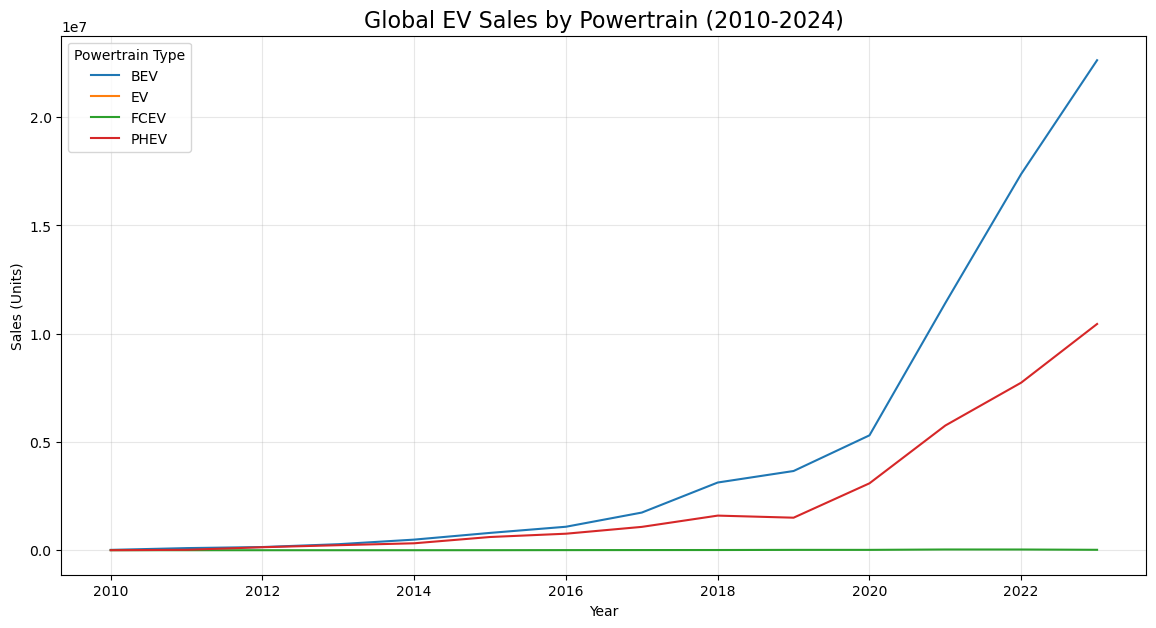

In [15]:
plt.figure(figsize=(14,7))
sns.lineplot(
    data=EV_sales_df,
    x='year',
    y='value',
    hue='powertrain',
    estimator='sum',
    errorbar=None
)
plt.title('Global EV Sales by Powertrain (2010-2024)', fontsize=16)
plt.ylabel('Sales (Units)')
plt.xlabel('Year')
plt.legend(title='Powertrain Type')
plt.grid(alpha=0.3)

#### 3.2 Regional Analysis

In [16]:
# Get top 15 countries by total sales
top_countries = EV_sales_df.groupby('region')['value'].sum().nlargest(15).index.tolist()

# Filtered dataset
filtered_EV_sales_df = EV_sales_df[EV_sales_df['region'].isin(top_countries)]

# Remove unused categories
filtered_EV_sales_df['region'] = filtered_EV_sales_df['region'].cat.remove_unused_categories()



/var/folders/dj/ckqj58_95nd2fh4jh63dy6x00000gn/T/ipykernel_29676/1340970672.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_countries = EV_sales_df.groupby('region')['value'].sum().nlargest(15).index.tolist()
/var/folders/dj/ckqj58_95nd2fh4jh63dy6x00000gn/T/ipykernel_29676/1340970672.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_EV_sales_df['region'] = filtered_EV_sales_df['region'].cat.remove_unused_categories()


/var/folders/dj/ckqj58_95nd2fh4jh63dy6x00000gn/T/ipykernel_29676/2030278968.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  EV_sales_df.groupby('region')['value'].sum().sort_values(ascending=False).head(15).plot(


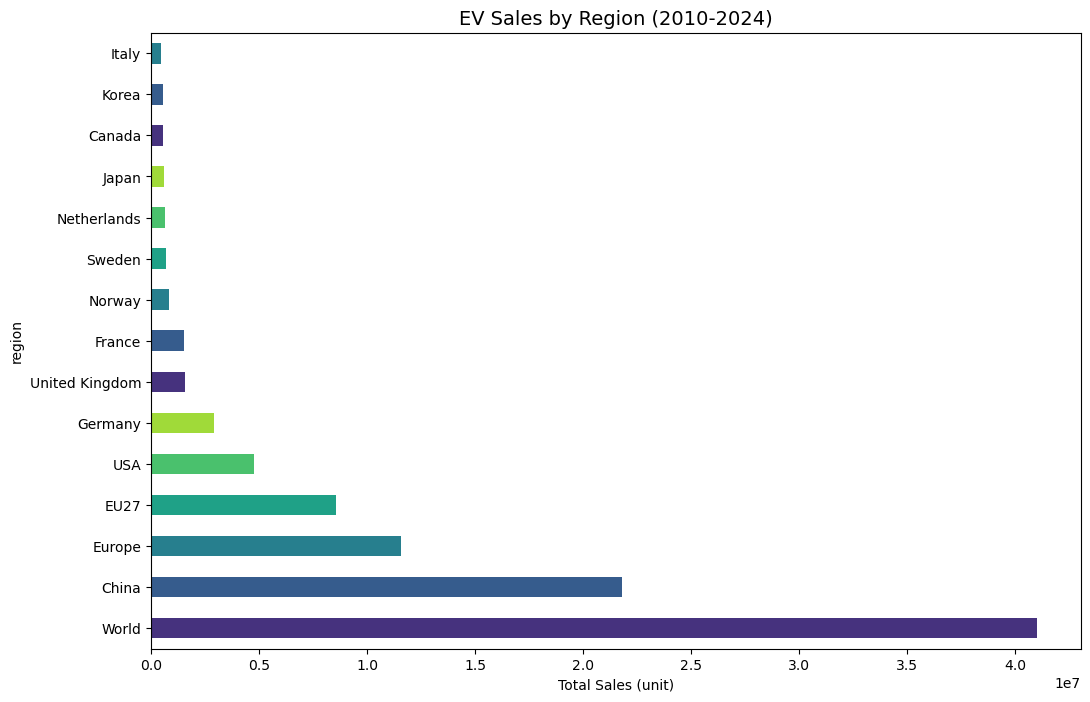

In [17]:
plt.figure(figsize=(12,8))
EV_sales_df.groupby('region')['value'].sum().sort_values(ascending=False).head(15).plot(
    kind='barh', 
    color=sns.color_palette('viridis'))
plt.title('EV Sales by Region (2010-2024)', fontsize=14)
plt.xlabel('Total Sales (unit)')
plt.show()

/var/folders/dj/ckqj58_95nd2fh4jh63dy6x00000gn/T/ipykernel_29676/988323784.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax=sns.lineplot(data=filtered_EV_sales_df.groupby('region')['value'].sum(), marker='o',label='Total sales')


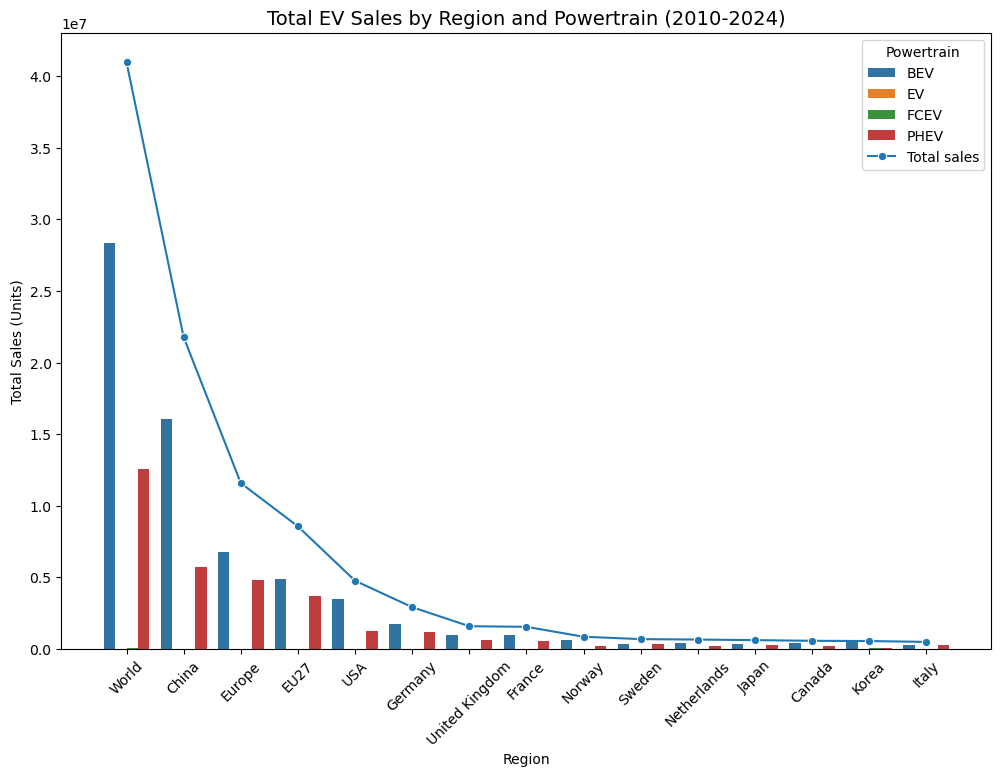

In [18]:
## Powertrain Preference by Region
plt.figure(figsize=(12,8))

sns.barplot(
    data=EV_sales_df,
    x='region',
    y='value',
    hue='powertrain',
    estimator='sum',
    errorbar=None,
    order= top_countries,
    legend=True
)

# Show the total sales value by line graph
ax=sns.lineplot(data=filtered_EV_sales_df.groupby('region')['value'].sum(), marker='o',label='Total sales')

plt.title('Total EV Sales by Region and Powertrain (2010-2024)', fontsize=14)
plt.ylabel('Total Sales (Units)')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.legend(title='Powertrain')

#### 3.3  Distributions

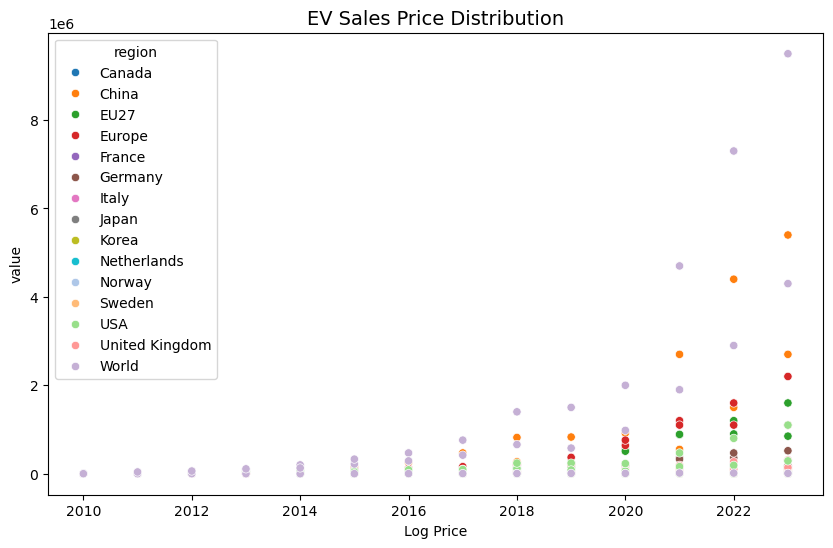

In [19]:
custom_palette = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5'
]


plt.figure(figsize=(10,6))
sns.scatterplot(x='year',y='value',data=filtered_EV_sales_df,hue='region',palette=custom_palette)

plt.title('EV Sales Price Distribution', fontsize=14)
plt.xlabel('Log Price')
plt.show()

/var/folders/dj/ckqj58_95nd2fh4jh63dy6x00000gn/T/ipykernel_29676/623416022.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count = df.groupby('parameter')['powertrain'].value_counts()


<AxesSubplot: ylabel='count'>

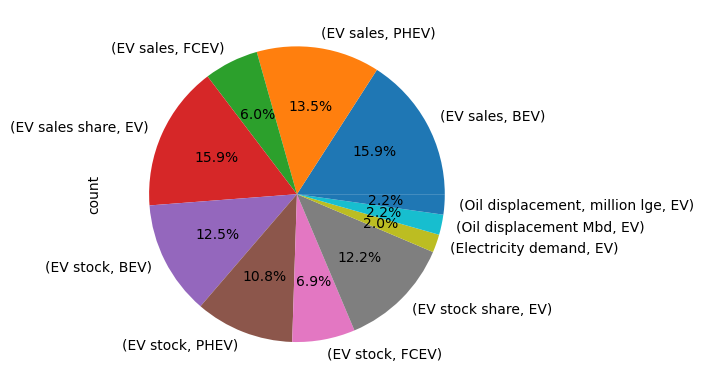

In [20]:
# Using pie chart to show the distribution of powertrain
count = df.groupby('parameter')['powertrain'].value_counts()

# Remove the piece that show 0%
count = count[count>0]
count.plot.pie(autopct='%1.1f%%')

#### 3.4 Correlations of The Data

Text(0.5, 1.0, 'Correlation among value, parameter and powertrain')

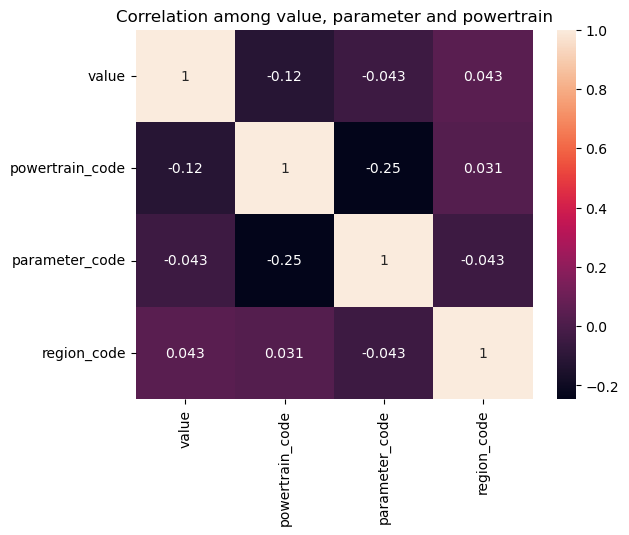

In [21]:
powertrain_map = {
    'BEV': 0,
    'PHEV': 1,
    'FCEV': 2,
    'EV': 3
}
parameter_map = {
    'EV sales': 6, 
    'EV stock share': 5, 
    'EV sales share': 4, 
    'EV stock': 3, 
    'Electricity demand': 2, 
    'Oil displacement Mbd': 1, 
    'Oil displacement, million lge': 0
    
}

region_map = {region: idx for idx, region in enumerate(df['region'].unique())}
df['region_code'] = df['region'].map(region_map)
df['powertrain_code'] = df['powertrain'].map(powertrain_map)
df['parameter_code'] = df['parameter'].map(parameter_map)
sns.heatmap(df[['value','powertrain_code','parameter_code','region_code']].corr(), annot=True)
plt.title('Correlation among value, parameter and powertrain')

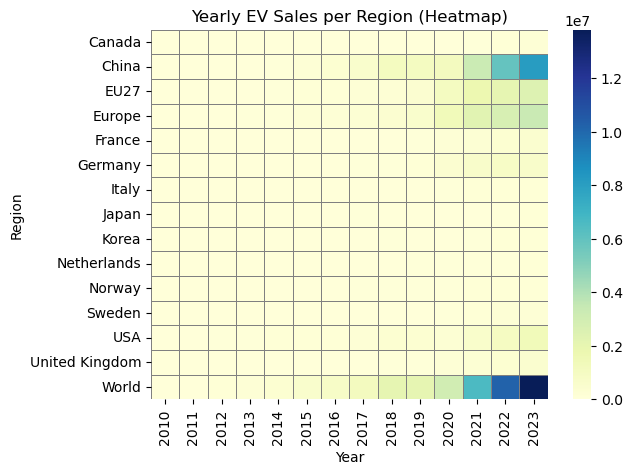

In [22]:
# Pivot table for heatmap
heatmap_data = filtered_EV_sales_df.pivot_table(
    index='region',
    columns='year',
    values='value',
    aggfunc='sum'
)
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.5, linecolor='gray')
plt.title('Yearly EV Sales per Region (Heatmap)')
plt.xlabel('Year')
plt.ylabel('Region')
plt.show()

## 4. Deep Dive Analysis

#### 4.1 Forecasting EV Sales Trends with Random Forest Regression

In [23]:
ml_df = df[df['parameter'] == 'EV sales'].groupby(['year','region_code','powertrain_code'])['value'].sum().reset_index()
ml_df.head()

/var/folders/dj/ckqj58_95nd2fh4jh63dy6x00000gn/T/ipykernel_29676/3377174272.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ml_df = df[df['parameter'] == 'EV sales'].groupby(['year','region_code','powertrain_code'])['value'].sum().reset_index()


,year,region_code,powertrain_code,value
0,2010,0,0,0.0
1,2010,0,3,0.0
2,2010,0,2,0.0
3,2010,0,1,0.0
4,2010,1,0,0.0


/var/folders/dj/ckqj58_95nd2fh4jh63dy6x00000gn/T/ipykernel_29676/583267652.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RMSE: 51198.1891346068
R²: 0.9152235469924282

Feature Importances:
year               0.357356
region_code        0.333561
powertrain_code    0.309083
dtype: float64


<AxesSubplot: title={'center': 'Feature Importance'}>

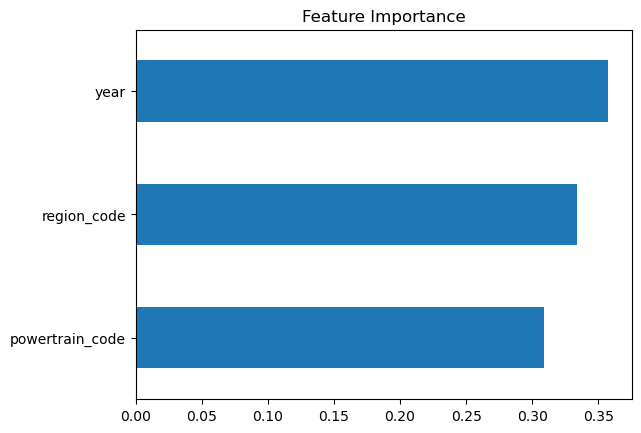

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Feature selection
X = ml_df[['year', 'region_code', 'powertrain_code']]
y= ml_df[['value']]

# using the train test split function
X_train, X_test, y_train, y_test = train_test_split(
  X,y , random_state=104,test_size=0.2, shuffle=True)

# Initialize and train model
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)

print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R²: {r2_score(y_test, y_pred)}")

# Feature importance
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
print("\nFeature Importances:")
print(feature_importances)
feature_importances.sort_values().plot(kind='barh', title='Feature Importance')



In [25]:
ml_df2 = EV_sales_df.groupby('year')['value'].sum().reset_index()
ml_df2


,year,value
0,2010,17481.0
1,2011,116745.0
2,2012,285910.0
3,2013,510334.0
4,2014,810712.2
5,2015,1412771.0
6,2016,1852523.0
7,2017,2825756.0
8,2018,4735114.0
9,2019,5177232.0


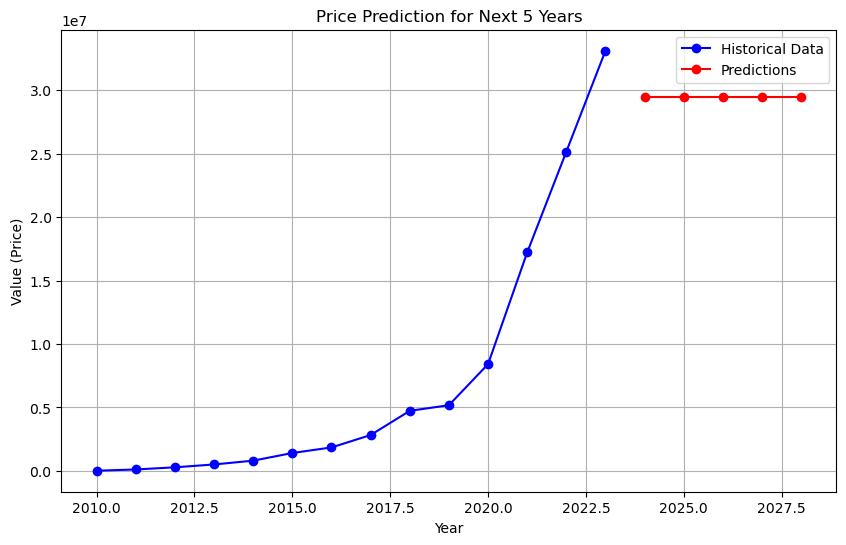

Future Predictions:
   year  predicted_value
0  2024      29449782.23
1  2025      29449782.23
2  2026      29449782.23
3  2027      29449782.23
4  2028      29449782.23


In [26]:
# Prepare features and target
X_train = ml_df2[['year']]  # Feature matrix (must be 2D array)
y_train = ml_df2['value']   # Target vector

# Train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Generate future years for prediction
last_year = ml_df2['year'].max()
future_years = np.arange(last_year + 1, last_year + 6)  # Next 5 years
X_future = pd.DataFrame(future_years, columns=['year'])

# Predict future values
future_predictions = model.predict(X_future)
X_future['predicted_value'] = future_predictions

# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(ml_df2['year'], ml_df2['value'], 'bo-', label='Historical Data')
plt.plot(X_future['year'], X_future['predicted_value'], 'ro-', label='Predictions')
plt.title('Price Prediction for Next 5 Years')
plt.xlabel('Year')
plt.ylabel('Value (Price)')
plt.legend()
plt.grid(True)
plt.show()

# Print predictions
print("Future Predictions:")
print(X_future)

#### 4.2 Forecasting EV Sales Trends with Linear Regression

In [40]:
# Generate future years for prediction
last_year = ml_df2['year'].max()
future_years = np.arange(last_year + 1, last_year + 6)  # Next 5 years
X_future = pd.DataFrame(future_years, columns=['year'])
X_future

,year
0,2024
1,2025
2,2026
3,2027
4,2028


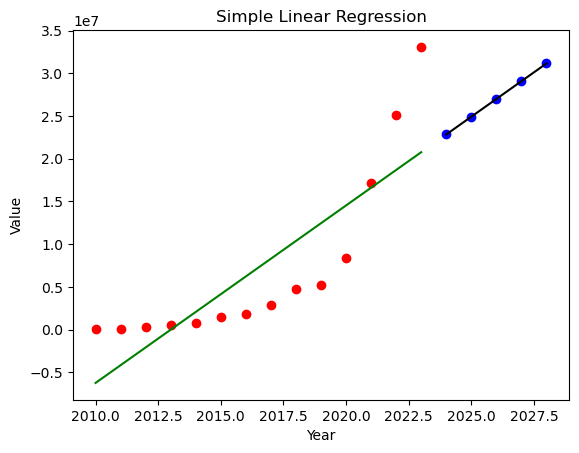

In [41]:
from scipy import stats
from sklearn.linear_model import LinearRegression


lin_reg=LinearRegression()
lin_reg.fit(X_train, y_train)

plt.scatter(X_train, y_train,color='red')
plt.plot(X_train,lin_reg.predict(X_train),color='green')
plt.title('Simple Linear Regression')
plt.xlabel('Year')
plt.ylabel('Value')


# Predict future values
future_predictions2 = lin_reg.predict(X_future)
X_future['predicted_value2'] = future_predictions2
plt.scatter(X_future['year'],X_future['predicted_value2'],color='blue')
plt.plot(X_future['year'],X_future['predicted_value2'],color='black')


plt.show()


#### 4.3 ARIMA Model

In [64]:
ml_df3=ml_df2.copy()
ml_df3.head()

,year,value
0,2010,17481.0
1,2011,116745.0
2,2012,285910.0
3,2013,510334.0
4,2014,810712.2


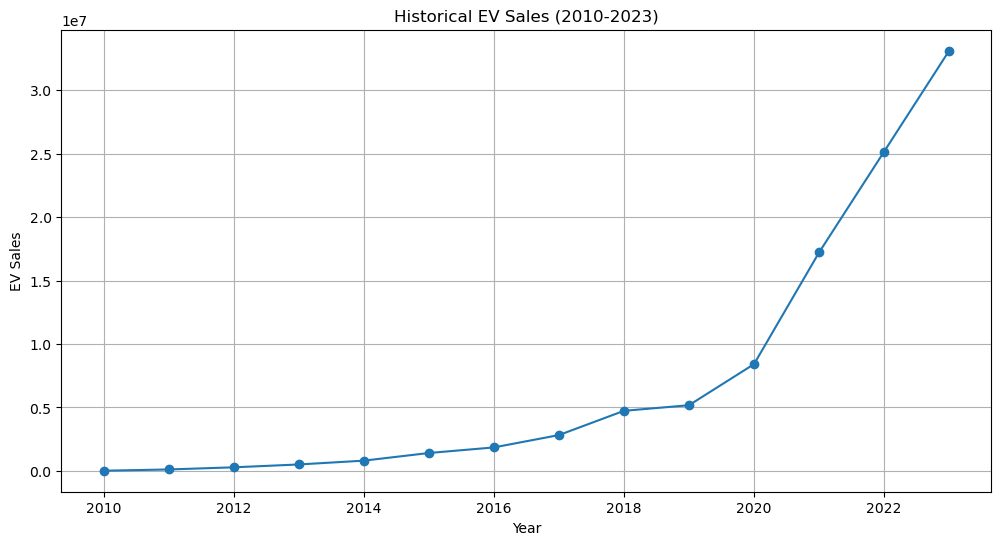

ADF Statistic: 2.327616872374379
p-value: 0.9989720657050878
Critical Values:
   1%: -4.473135048010974
   5%: -3.28988060356653
   10%: -2.7723823456790124


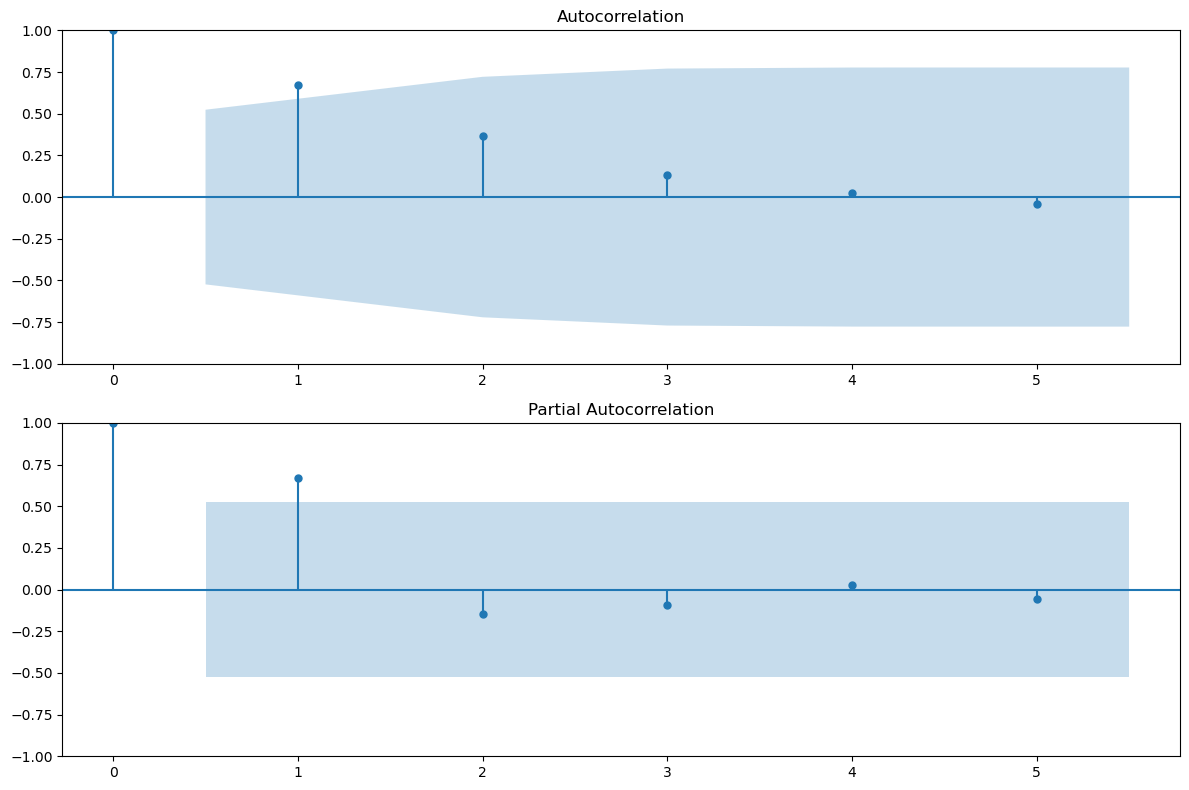

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Plot historical data
plt.figure(figsize=(12, 6))
plt.plot(ml_df3['year'],ml_df3['value'],marker='o')
plt.title('Historical EV Sales (2010-2023)')
plt.xlabel('Year')
plt.ylabel('EV Sales')
plt.grid(True)
plt.show()


# Check stationarity using Augmented Dickey-Fuller test
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    
test_stationarity(ml_df3['value'])

# Plot ACF and PACF to determine AR/MA orders
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(ml_df3['value'], lags=5, ax=ax1)
plot_pacf(ml_df3['value'], lags=5, ax=ax2, method='ywm')
plt.tight_layout()
plt.show()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=430.562, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=416.028, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=424.774, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=434.882, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=418.058, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=418.095, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.445 seconds
Best ARIMA parameters: (1, 1, 0)
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   14
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -205.826
Date:                Tue, 10 Jun 2025   AIC                            415.652
Time:              

/Users/dengxifen/opt/anaconda3/envs/gpu2/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


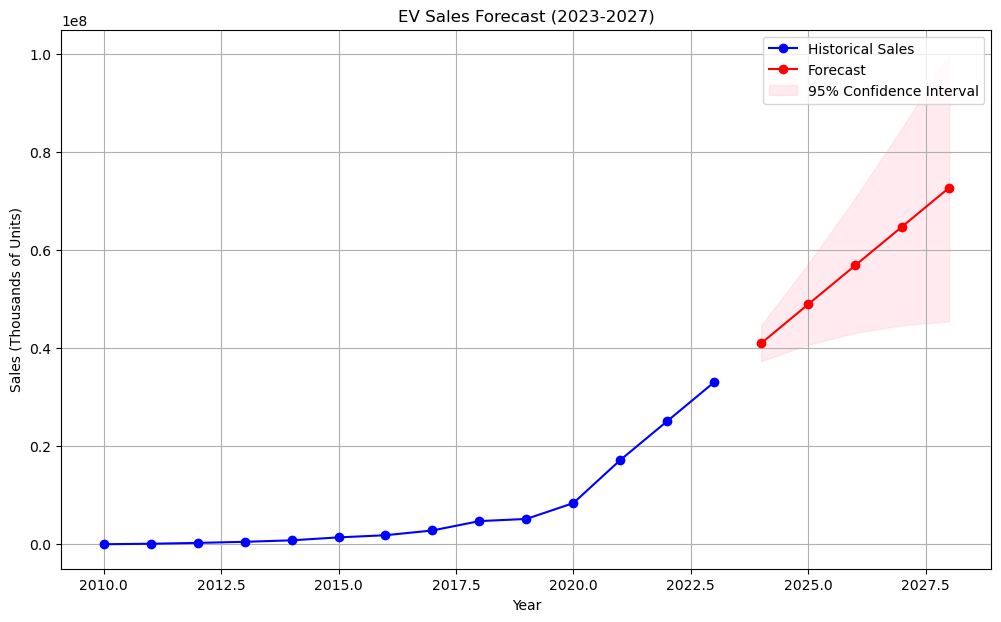


5-Year EV Sales Forecast:
   year  predicted_sales
0  2024     4.104290e+07
1  2025     4.898213e+07
2  2026     5.691657e+07
3  2027     6.484622e+07
4  2028     7.277107e+07

Forecast with Confidence Intervals:
   year  predicted_sales   lower_bound   upper_bound
0  2024     4.104290e+07  3.736499e+07  4.472081e+07
1  2025     4.898213e+07  4.076006e+07  5.720421e+07
2  2026     5.691657e+07  4.316161e+07  7.067153e+07
3  2027     6.484622e+07  4.471565e+07  8.497678e+07
4  2028     7.277107e+07  4.552039e+07  1.000218e+08


In [ ]:
# Automatically find best ARIMA parameters using auto_arima


auto_model = auto_arima(
    ml_df3['value'],
    start_p=0, 
    start_q=0,
    max_p=3, 
    max_q=3,
    d=None,           # Let model determine differencing
    seasonal=False,   # No seasonal component
    trace=True,       # Show search process
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(f"Best ARIMA parameters: {auto_model.order}")

# Fit ARIMA model with best parameters
model = ARIMA(ml_df3['value'], order=auto_model.order)
results = model.fit()

# Print model summary
print(results.summary())

# Forecast next 5 years (2023-2027)
forecast_steps = 5
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)  # 95% confidence interval

# Create future index
future_years = [2023 + i for i in range(1,6)]

# Prepare results dataframe
forecast_df = pd.DataFrame({
    'year': future_years,
    'predicted_sales': forecast_mean.values,
    'lower_bound': conf_int.iloc[:, 0].values,
    'upper_bound': conf_int.iloc[:, 1].values
})

# Visualize results
plt.figure(figsize=(12, 7))
plt.plot(ml_df3['year'],ml_df3['value'], 'bo-', label='Historical Sales')
plt.plot(future_years, forecast_mean, 'ro-', label='Forecast')
plt.fill_between(
    future_years,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color='pink',
    alpha=0.3,
    label='95% Confidence Interval'
)

plt.title('EV Sales Forecast (2023-2027)')
plt.xlabel('Year')
plt.ylabel('Sales (Thousands of Units)')
plt.legend()
plt.grid(True)
plt.show()

# Print forecast results
print("\n5-Year EV Sales Forecast:")
print(forecast_df[['year', 'predicted_sales']])
print("\nForecast with Confidence Intervals:")
print(forecast_df)